In [1]:
import pandas as pd
import numpy as np

import squarify
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
orders = pd.read_csv('olist_orders_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [3]:
columns_timestamp = ['order_purchase_timestamp','order_approved_at',
                     'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for column in columns_timestamp:
    orders[column] = pd.to_datetime(orders[column])

In [4]:
order_items_silver = order_items.groupby('order_id').agg({'price':sum,'freight_value':sum,'shipping_limit_date':max }).reset_index()
orders_silver = orders.merge(order_items_silver,on='order_id',how='inner')
orders_customers = customers.merge(orders_silver, on='customer_id', how='inner')
max_date = max(orders_customers['order_purchase_timestamp']) + datetime.timedelta(days=1)

In [5]:
rfm_data = orders_customers.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'customer_id':'count',
    'price':'sum'
}).reset_index()
rfm_data.columns =['customer_id','recency','frequency','monetary']

In [19]:
def k_means_group(data, n_clusters, random_state, asc=False, log_transf=False, standard_tranf=False):
    
    data_temp = data.copy()

    if standard_tranf:
        scaler = StandardScaler()
        scaler = scaler.fit(data_temp)
        data_temp = scaler.transform(data_temp)
        
    kmeans_sel = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_temp)
    cluster_group = data.assign(cluster = kmeans_sel.labels_)
    #return cluster_group
    mean_group = cluster_group.groupby('cluster').mean().reset_index()
    #return mean_group
    mean_group = mean_group.sort_values(by=mean_group.columns[1],ascending=asc)
    mean_group['cluster_set'] = [i for i in range(n_clusters, 0, -1) ]
    cluster_map = mean_group.set_index('cluster').to_dict()['cluster_set']
    return cluster_group['cluster'].map(cluster_map)

In [20]:
r_labels = k_means_group(rfm_data[['recency']],5,1,asc=True)
r_labels

,cluster,recency
0,0,262.680688
1,1,52.518080
2,2,514.573759
3,3,156.245092
4,4,379.632672


In [7]:
r_labels = k_means_group(rfm_data[['recency']],5,1,asc=True)
f_labels = k_means_group(rfm_data[['frequency']],5,1)
m_labels = k_means_group(rfm_data[['monetary']],5,1)

rfm_data = rfm_data.assign(R = r_labels, F = f_labels, M = m_labels)

In [20]:
def get_segment(data):
    mean_fm = (data['F'] + data['M']) / 2
    
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
        return 'MVC'
    if (data['R'] >= 0 and data['R'] <= 3) and (mean_fm >= 3 and mean_fm <= 5):
        return 'Prudent seekers'
    if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
        return 'Regular Customers'
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
        return 'New Customers'
    if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Promising'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
        return 'Customer Needing Attention'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
        return 'Irregular customers'
    if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
        return 'Long time no See Customers'
    if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
        return "Losing yet important Customers"
    if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
        return 'Least Value'

In [21]:
rfm_data['segment'] = rfm_data.apply(get_segment,axis=1)

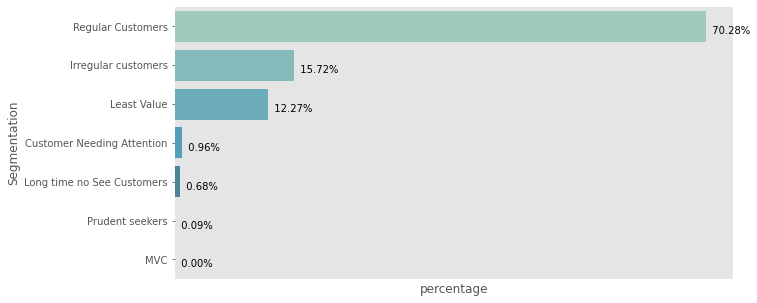

In [22]:
plt.figure(figsize=(10,5))
percentage = (rfm_data['segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['percentage']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()